### SOCIAL NETWORK ANLYSIS PROJECT

# GitHub repositories as a Collaborative Network

#### Released by :Khalid OUHMAID ,Taleb bouye med vadel , MSOUHLI Aymen

#### Supervised by: Prof. Lamia Benhiba

## Building a simple network around tensorflow

In [2]:
from github import Github 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

ACCESS_TOKEN = '296f30c33c9baa330f3dc58fd4f7a9ac4e1c4245 '
g = Github(ACCESS_TOKEN, per_page=100)

USER = 'K-Ouhmaid'
REPO = 'tensorflow'

user = g.get_user(USER)
#repo = user.get_repo(REPO)

with open('keys.txt') as keys: # file with user details 
    details = [line.split('\n')[0] for line in keys]    
    keys.close
    
#g = Github(details[0], details[1]) # access github via login details

In [3]:
tf = g.search_repositories('tensorflow', sort = 'stars', order = 'desc') #find the tensorflow repository
tf[0].name

'tensorflow'

In [4]:
contri = tf[0].get_contributors() # contributor data
''' 
list of contributors who have made more than 10 contributions to tf
only including named contributors for now'''
cont_list = [c.name for c in contri if c.contributions > 10 and c.name != None]
len(cont_list) 

345

In [5]:
top_tf_contributor = cont_list[0]
second_tf_contributor = cont_list[1] #
print('top:', top_tf_contributor, 'second:', second_tf_contributor)

top: TensorFlower Gardener second: Gunhan Gulsoy


In [6]:
##  look at the top ten contributors
stats_cont = tf[0].get_stats_contributors()
stats_cont_totals = {'login':[], 'total_cont':[] }
stats_cont_deletions = {}
stats_cont_additions = {}
stats_cont_commits = {}
stats_cont_week = {}

for c in range(len(stats_cont)):
    if stats_cont[c].total > 10:
        stats_cont_totals['login'].append(stats_cont[c].author.login) 
        stats_cont_totals['total_cont'].append(stats_cont[c].total)
        stats_cont_deletions[stats_cont[c].author.login] = [stats_cont[c].weeks[i].d for i in range(len(stats_cont[c].weeks))]
        stats_cont_additions[stats_cont[c].author.login] = [stats_cont[c].weeks[i].a for i in range(len(stats_cont[c].weeks))]
        stats_cont_commits[stats_cont[c].author.login] = [stats_cont[c].weeks[i].c for i in range(len(stats_cont[c].weeks))]
        stats_cont_week[stats_cont[c].author.login] = [stats_cont[c].weeks[i].w for i in range(len(stats_cont[c].weeks))]

In [7]:
totals = pd.DataFrame.from_dict(stats_cont_totals)

<BarContainer object of 10 artists>

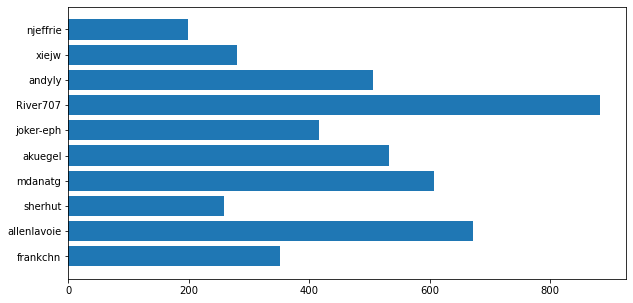

In [8]:
# plot total contribution of top ten contributors
fig, ax = plt.subplots(figsize = (10,5))
ax.barh(totals['login'][-10:], totals['total_cont'][-10:] )

In [9]:
# the activity of top 3 contributors over time
commits = pd.DataFrame.from_dict(stats_cont_commits)
deletions = pd.DataFrame.from_dict(stats_cont_deletions)
additions = pd.DataFrame.from_dict(stats_cont_additions)
weeks= pd.DataFrame.from_dict(stats_cont_week)

No handles with labels found to put in legend.


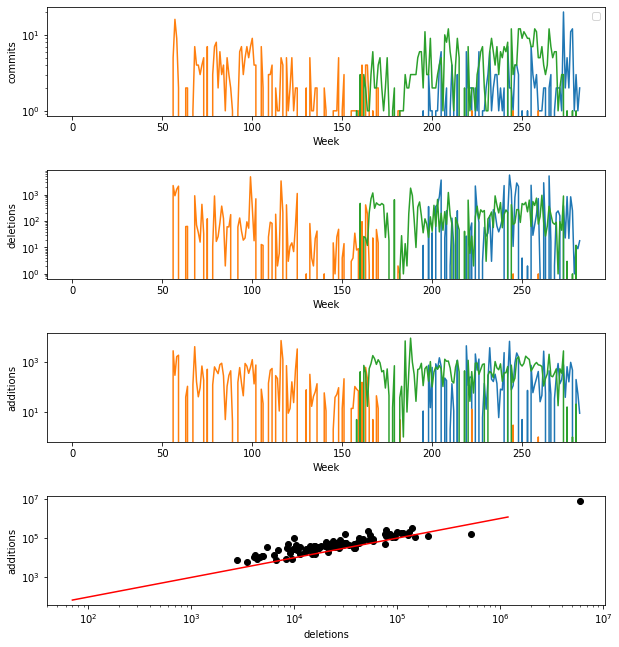

In [10]:
# plot activity over time
top_3_users = totals['login'][-3:].tolist()
fig,ax = plt.subplots(nrows=4, figsize = (10,11))

ax[0].plot(commits[top_3_users[2]])
ax[1].plot(deletions[top_3_users[2]])
ax[2].plot(additions[top_3_users[2]])

ax[0].plot(commits[top_3_users[1]])
ax[1].plot(deletions[top_3_users[1]])
ax[2].plot(additions[top_3_users[1]])

ax[0].plot(commits[top_3_users[0]])
ax[1].plot(deletions[top_3_users[0]])
ax[2].plot(additions[top_3_users[0]])

#sum all deletions and addtions for each user, what is the relationship between code addition and deletion?
del_sum = deletions.sum(axis = 0)
add_sum = additions.sum(axis = 0)

ax[3].scatter(del_sum,add_sum, color = 'black') # remove tensorflower-gardener
ax[3].plot([70,1190000],[70,1190000], color = 'red')
# set labels 
ax[0].set_ylabel('commits')
ax[1].set_ylabel('deletions')
ax[2].set_ylabel('additions')
ax[0].set_xlabel('Week')
ax[1].set_xlabel('Week')
ax[2].set_xlabel('Week')
ax[3].set_ylabel('additions')
ax[3].set_xlabel('deletions')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')
ax[3].set_xscale('log')
ax[0].legend()
# increase height between subplots
fig.subplots_adjust(hspace = 0.5)

### how are commonly associated repositories connected?

In [11]:
tb = g.search_repositories('tensorflow/tensorboard', sort = 'stars', order = 'desc') #tensorboard repository
mo = g.search_repositories('tensorflow/models', sort = 'stars', order = 'desc') #tensorflow models repository
pt = g.search_repositories('pytorch', sort = 'stars', order = 'desc') #pytorch repository
kr = g.search_repositories('keras', sort = 'stars', order = 'desc') #keras repo
tj = g.search_repositories('tensorflow/tfjs-core', sort = 'stars', order = 'desc') #tfjs-core repo

In [12]:
import networkx as nx
from itertools import combinations 
from itertools import count

In [13]:
# function to output dict for networkx
## consider size of repo (by number of contributors), names of contributors, repo name, 

G = nx.Graph() # total graph
U = nx.Graph() # user graph
R = nx.MultiGraph() # repo graph

def repo_to_network(repo):
    cont = repo.get_contributors()
    cont_name = [c.login for c in cont if c.contributions > 20]
    cont_num = [c.contributions for c in cont if c.contributions> 20]
    cont_comp = [c.company for c in cont if c.contributions > 20]
    
    G.add_node(repo.name, node_type = 'project', reponame= repo.name, num_contributors= len(cont_name), language= repo.language)
    R.add_node(repo.name, node_type = 'project', reponame= repo.name, num_contributors= len(cont_name), language= repo.language)
    for c in range(len(cont_name)):
        G.add_node(cont_name[c], node_type = 'user', company= cont_comp[c], num_contributions=cont_num[c]) # add nodes
        G.add_edge(cont_name[c], repo.name) # add edge from user to repo
        R.add_edge(cont_name[c], repo.name)
        U.add_node(cont_name[c], node_type = 'user', company= cont_comp[c], num_contributions=cont_num[c])
    U.add_edges_from(combinations(cont_name,2))

In [14]:
repo_to_network(tf[0])

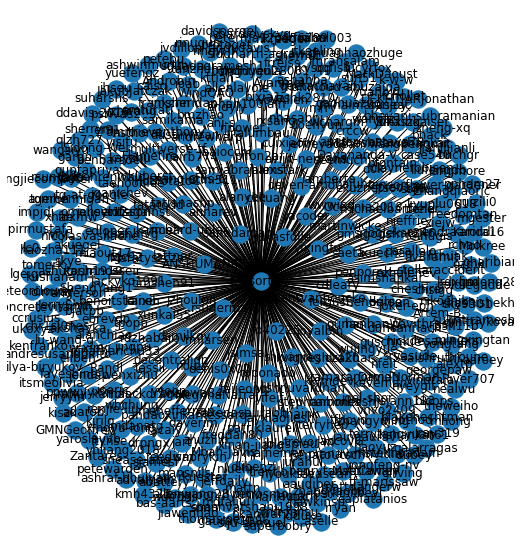

In [15]:
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
nx.draw(G, with_labels = True)

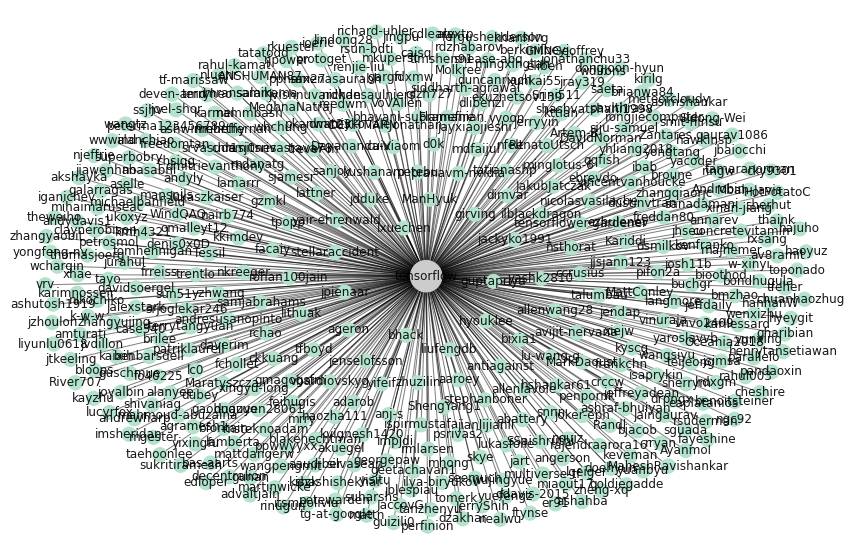

In [16]:
# different colormap for projects and users
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (15,10))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
plt.axis('off')
plt.show()

#### Incrementally building a network

In [17]:
repo_to_network(tb[0]) # add tensorboard to network

In [18]:
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (15,10))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
plt.axis('off')
plt.show()

In [19]:
repo_to_network(mo[0])

In [20]:
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (20,20))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
plt.axis('off')
plt.show()

In [21]:
repo_to_network(kr[0])

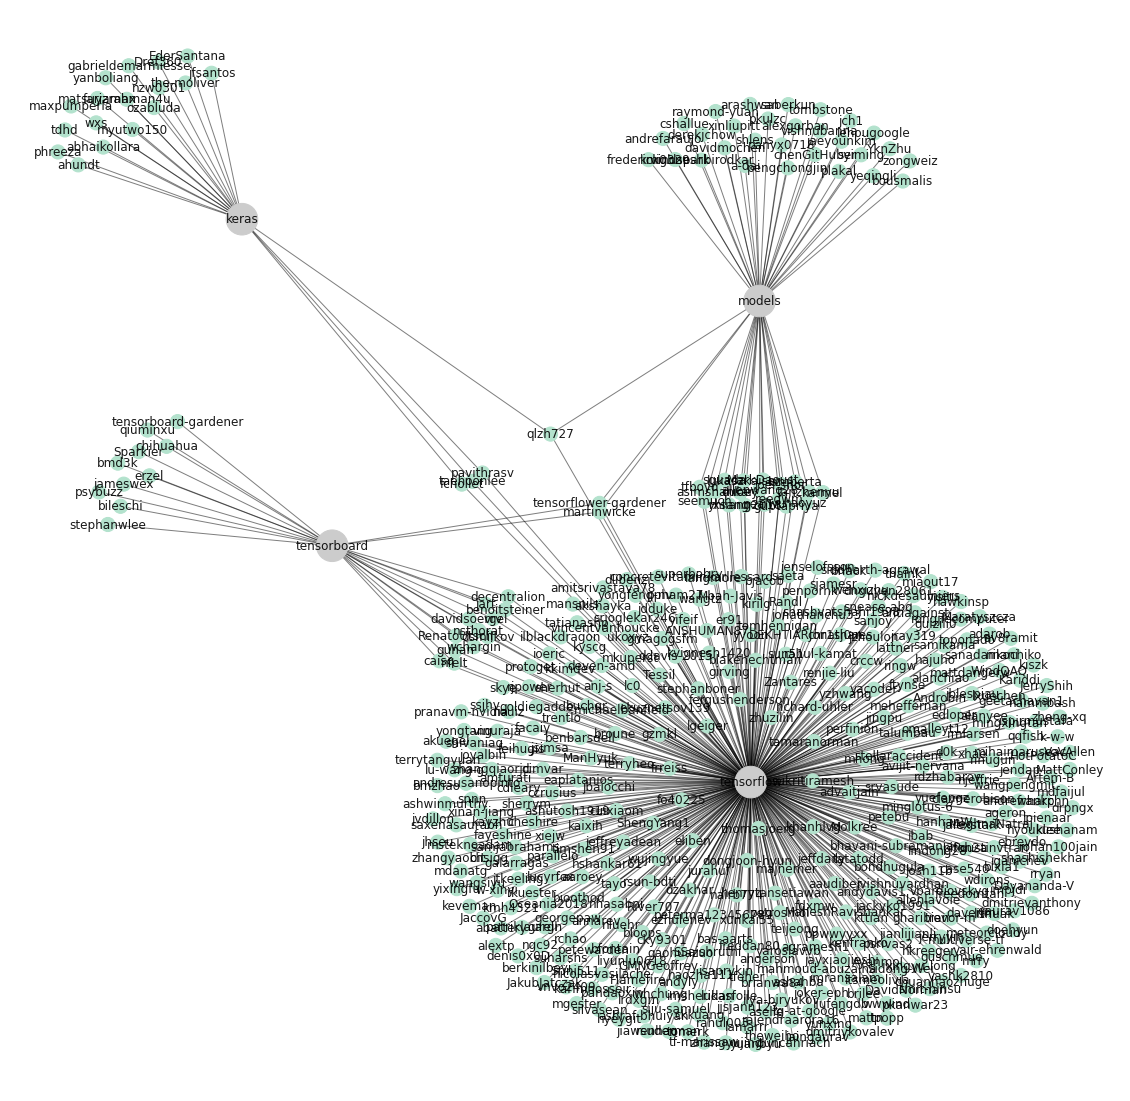

In [22]:
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (20,20))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
plt.axis('off')
plt.show()

In [23]:
repo_to_network(tj[0])

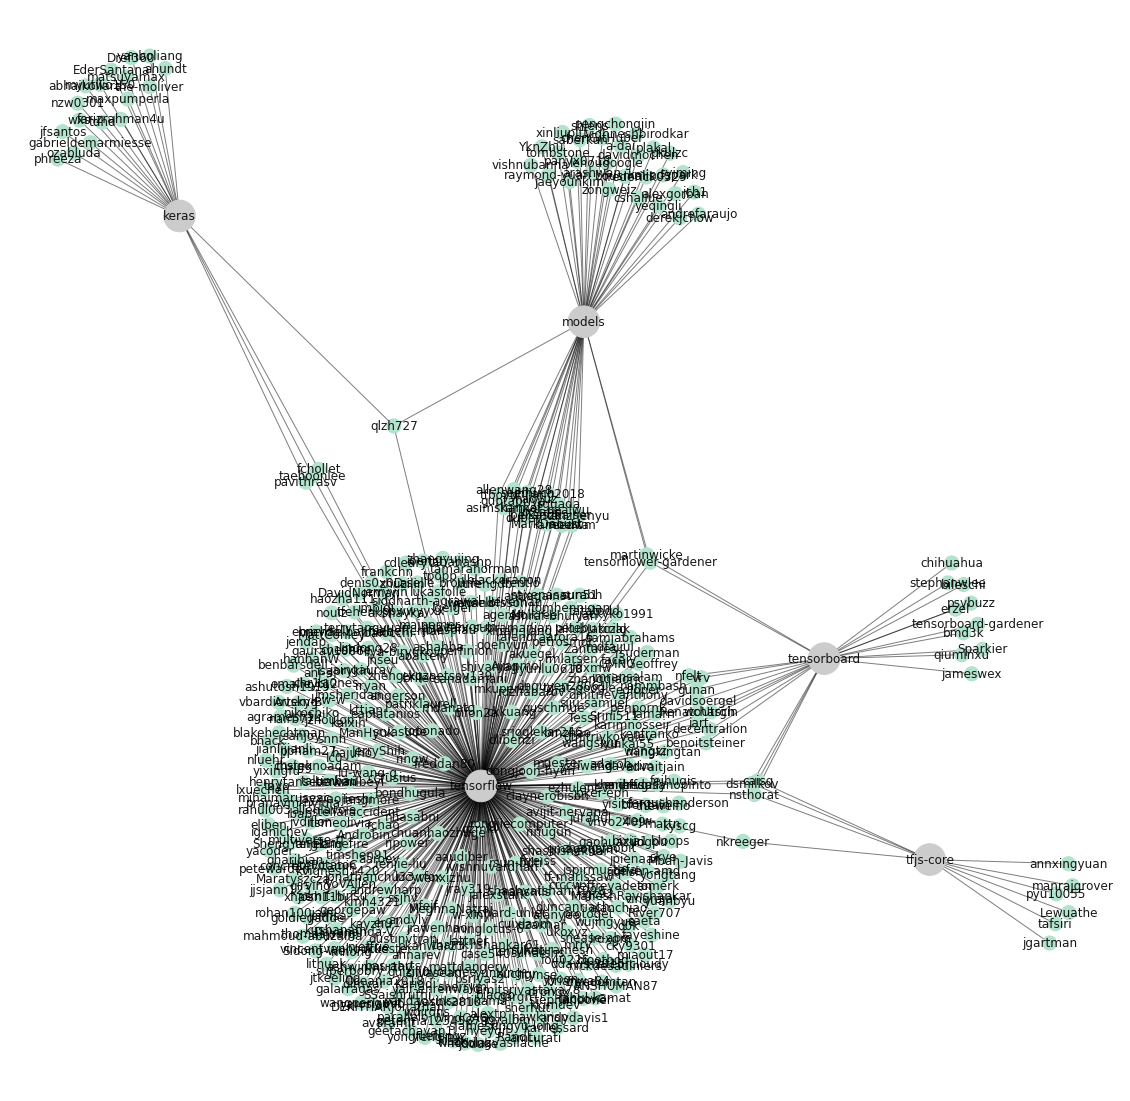

In [24]:
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (20,20))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
#plt.colorbar(nc)
plt.axis('off')
plt.show()

In [25]:
repo_to_network(pt[0])

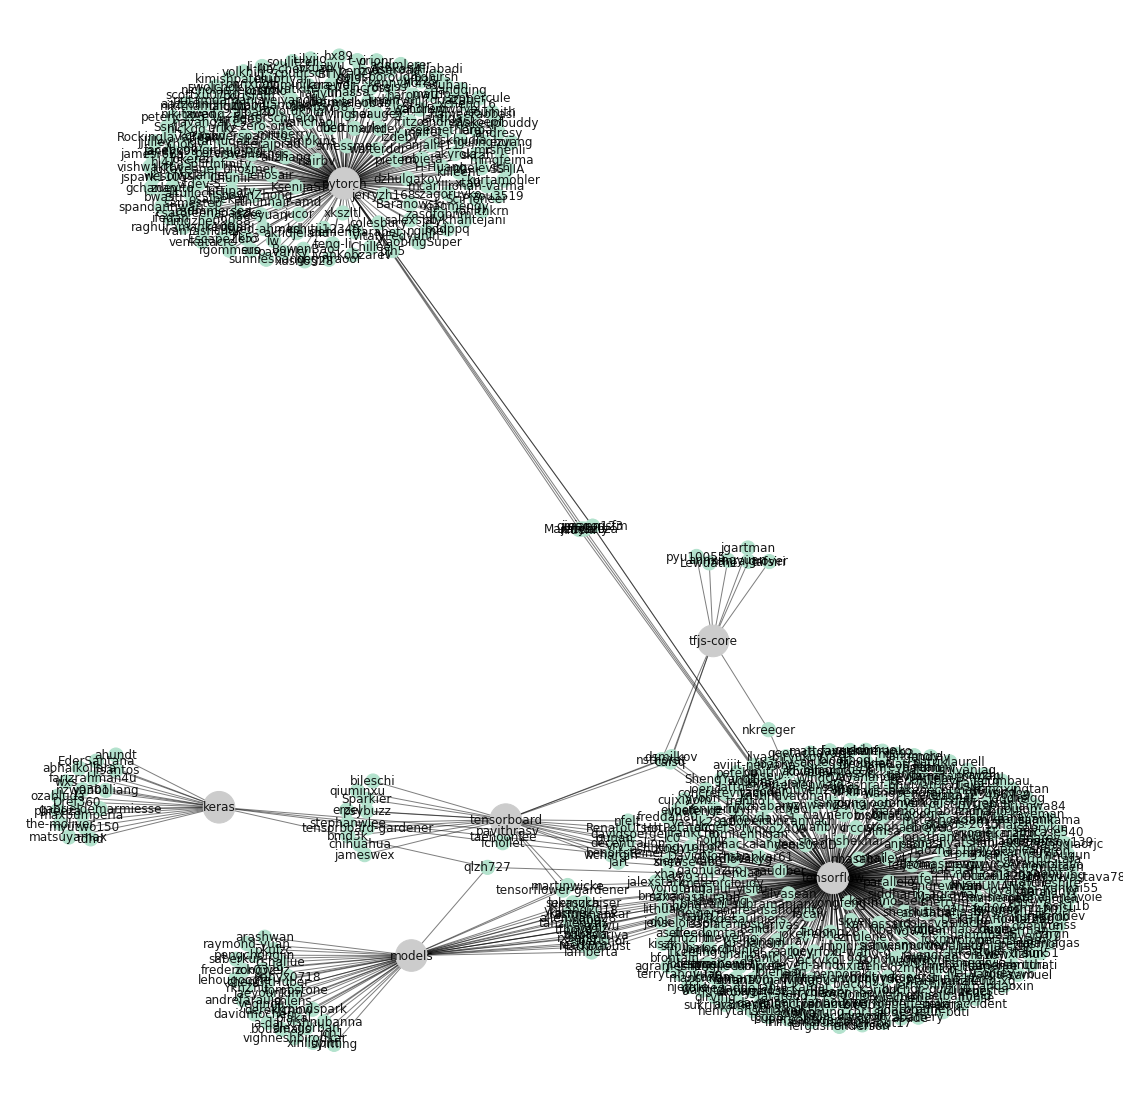

In [26]:
groups = set(nx.get_node_attributes(G,'node_type').values())
mapping = dict(zip(groups, [1000,200]))
nodes = G.nodes()
colors = [mapping[G.nodes[n]['node_type']] for n in nodes]



# drawing nodes and edges separately so we can capture collection for colobar
fig = plt.figure(figsize = (20,20))
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=True, node_size=colors, cmap=plt.cm.Pastel2)
lc = nx.draw_networkx_labels(G, pos, alpha = 0.9)
#plt.colorbar(nc)
plt.axis('off')
plt.show()

#### Exploring some features of the graph using functions and algorithms in networkx

In [27]:
print(nx.info(G)) # graph summary

Name: 
Type: Graph
Number of nodes: 665
Number of edges: 707
Average degree:   2.1263


In [28]:
#  the common neighbors is easy
mo_tf = sorted(nx.common_neighbors(G, 'models', 'tensorflow'))
mo_tb = sorted(nx.common_neighbors(G, 'models', 'tensorboard'))

print('neighbors between models and tensorflow:',mo_tf, '\nneighbors between models and tensorboard:', mo_tb)

neighbors between models and tensorflow: ['MarkDaoust', 'allenwang28', 'asimshankar', 'dubey', 'guptapriya', 'haoyuz', 'joel-shor', 'karmel', 'lamberta', 'lukaszkaiser', 'martinwicke', 'nealwu', 'qlzh727', 'reedwm', 'rxsang', 'seemuch', 'sguada', 'tanzhenyu', 'tensorflower-gardener', 'tfboyd', 'yhliang2018'] 
neighbors between models and tensorboard: ['martinwicke', 'tensorflower-gardener']


In [29]:
nx.density(G) # the graph is really sparse due to lack of connectivity between repositories

0.003202282815472416

In [31]:
nx.node_connectivity(G)

1

In [32]:
# Pearson correlation coefficient of degree between linked nodes
nx.degree_assortativity_coefficient(G) # negative value illustrates that the network is dissortative 

-0.6813210889758464

#### How do each repository contribute to the network?

In [33]:
# average neighbor degree
repo = ['tensorflow','tensorboard','models','tfjs-core','keras','pytorch']

n_d = nx.average_neighbor_degree(G)

for r in repo:
    print(r, n_d[r]) 
'''
tensorboard appears to have the highest neighbor degree since half of the contributors also contributed to tensorflow,
tfjs-core or models. 

'''

tensorflow 1.1182266009852218
tensorboard 1.7916666666666667
models 1.48
tfjs-core 1.7
keras 1.2380952380952381
pytorch 1.0255102040816326


'\ntensorboard appears to have the highest neighbor degree since half of the contributors also contributed to tensorflow,\ntfjs-core or models. \n\n'

In [34]:
d_c = nx.degree_centrality(G)

for r in repo:
    print(r, d_c[r])
    
'''As expected, tensorflow is most central, since most users in the tensorflow organisation contributed to tf'''

tensorflow 0.6114457831325302
tensorboard 0.03614457831325302
models 0.07530120481927711
tfjs-core 0.015060240963855422
keras 0.03162650602409639
pytorch 0.29518072289156627


'As expected, tensorflow is most central, since most users in the tensorflow organisation contributed to tf'

In [35]:
c_c = nx.closeness_centrality(G)

for r in repo:
    print(r, c_c[r])
    
'''Similar trends with closeness centrality'''

tensorflow 0.5651063829787234
tensorboard 0.281475201356507
models 0.29059080962800876
tfjs-core 0.27135267674703717
keras 0.28076109936575055
pytorch 0.3844817602779386


'Similar trends with closeness centrality'

### how do within-topic networks look?

In [36]:
GT = g.search_repositories('topic:graph-theory',sort = 'stars', order = 'desc') # searching for graph-theory topic

In [37]:
for i in range(15): # lets look at the top 15 from the search
    print(GT[i].name)

Algorithms
networkx
cytoscape.js
grakn
mgmt
awesome-network-analysis
d3graphTheory
snake
Graph
Network-Analysis-Made-Simple
LightGraphs.jl
QuickQanava
awspx
graph
Mathematics


In [38]:
def repo_to_network_2(repo, graph): # modified to reduce bloat
    cont = repo.get_contributors()
    cont_name = [c.login for c in cont if c.contributions > 10]
    cont_num = [c.contributions for c in cont if c.contributions> 10]
    cont_comp = [c.company for c in cont if c.contributions > 10]
    
    graph.add_node(repo.name, node_type = 'project', reponame= repo.name, num_contributors= len(cont_name), language= repo.language)
    for c in range(len(cont_name)):
        graph.add_node(cont_name[c], node_type = 'user', company= cont_comp[c], num_contributions=cont_num[c], language =  '') # add nodes
        graph.add_edge(cont_name[c], repo.name) # add edge from user to repo     

In [39]:
gtgraph = nx.Graph() # initialise graph

for i in range(5): # add top 5 in search to graph, tried 10 and the graph was unreadable due to excessive white space
    repo_to_network_2(GT[i], gtgraph)

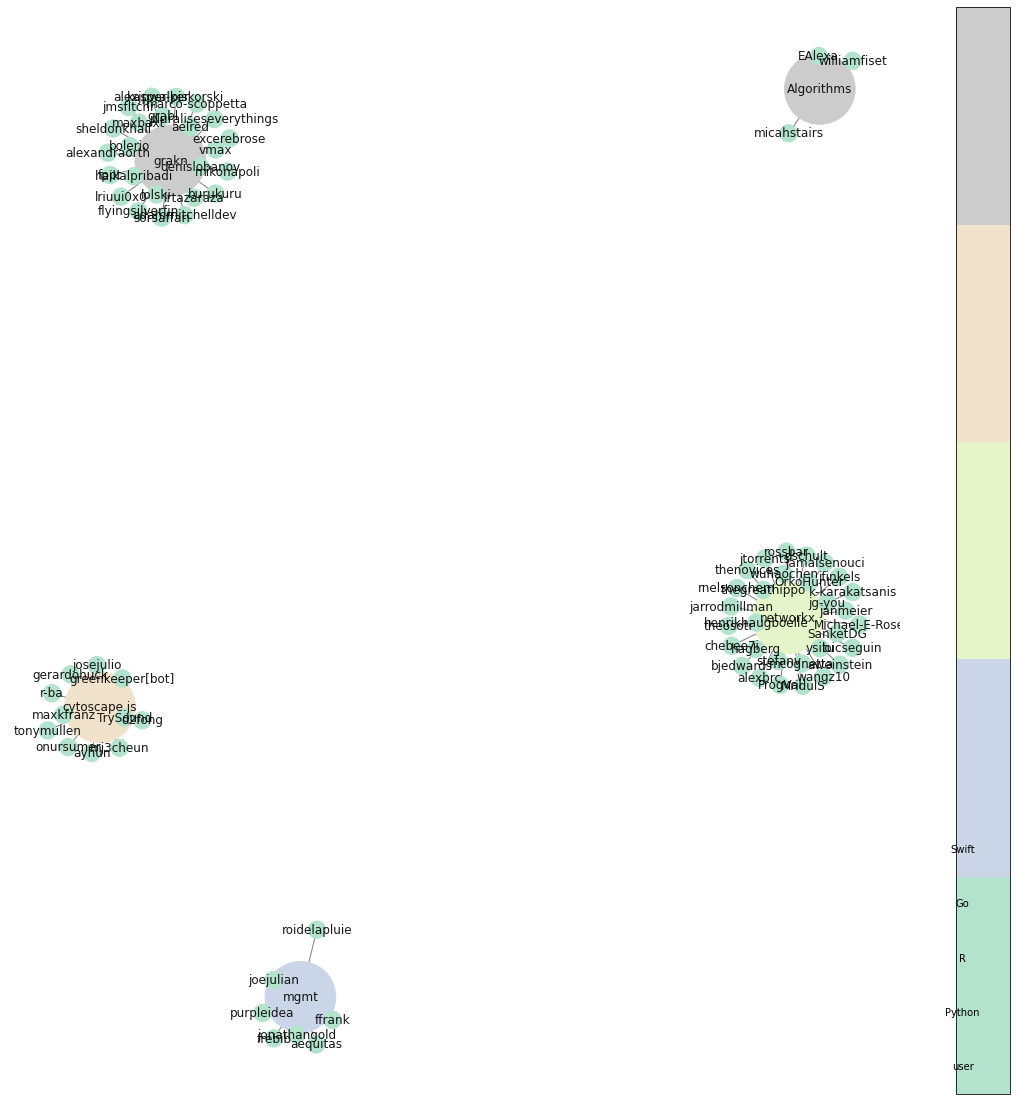

In [40]:
from itertools import  count
# set size
groups_type = set(nx.get_node_attributes(gtgraph,'node_type').values())
mapping_type = dict(zip(groups_type, [5000,300])) 
nodes = gtgraph.nodes()
size = [mapping_type[gtgraph.nodes[n]['node_type']] for n in nodes]

# set colors according to language
groups_lang = set(nx.get_node_attributes(gtgraph,'language').values())
mapping_lang = dict(zip(groups_lang, count()))
color = [mapping_lang[gtgraph.nodes[n]['language']] for n in nodes]

# draw nodes and edges separately 
fig = plt.figure(figsize = (20,20))
pos = nx.spring_layout(gtgraph)
ec = nx.draw_networkx_edges(gtgraph, pos, alpha=0.5)
nc = nx.draw_networkx_nodes(gtgraph, pos, nodelist=nodes, node_color=color, 
                            label=True, node_size=size, cmap=plt.cm.get_cmap('Pastel2', 5))
lc = nx.draw_networkx_labels(gtgraph, pos, alpha = 0.9)

# set colorbar
cbar = plt.colorbar(nc)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['user','Python','R','Go', 'Swift']):
    cbar.ax.text(.5, (2 * j + 1) /10, lab, ha='center', va='center')


plt.axis('off')
plt.show()

In [41]:
#large projects and how they collaborate

ranked_repos = g.search_repositories('stars:>1000',sort = 'stars', order = 'desc')

In [42]:
for i in range(10):
    print(ranked_repos[i])

Repository(full_name="freeCodeCamp/freeCodeCamp")
Repository(full_name="996icu/996.ICU")
Repository(full_name="EbookFoundation/free-programming-books")
Repository(full_name="vuejs/vue")
Repository(full_name="facebook/react")
Repository(full_name="jwasham/coding-interview-university")
Repository(full_name="sindresorhus/awesome")
Repository(full_name="tensorflow/tensorflow")
Repository(full_name="kamranahmedse/developer-roadmap")
Repository(full_name="twbs/bootstrap")
